In [ ]:
from utils import *

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda:0


In [ ]:
drive_dir = "/content/drive/MyDrive/OCT PVD/ZhangLabData/"
drive_dir = "/content/"
drive_dir = ""

train_dir = drive_dir + "CellData/OCT/train"
test_dir = drive_dir + "CellData/OCT/test"

In [ ]:
import cv2
import numpy as np
import torch
from torchvision import transforms

class GaussianBlur:
    def __call__(self, img):
        # Convert PIL image to numpy array for OpenCV
        img = np.array(img)
        # Apply Gaussian blur to reduce noise
        denoised_img = cv2.GaussianBlur(img, (5, 5), 0)
        # denoised_img = cv2.fastNlMeansDenoising(img, None, h=10, templateWindowSize=7, searchWindowSize=21)
        # denoised_img = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

        # Convert back to PIL format
        return transforms.functional.to_pil_image(denoised_img)

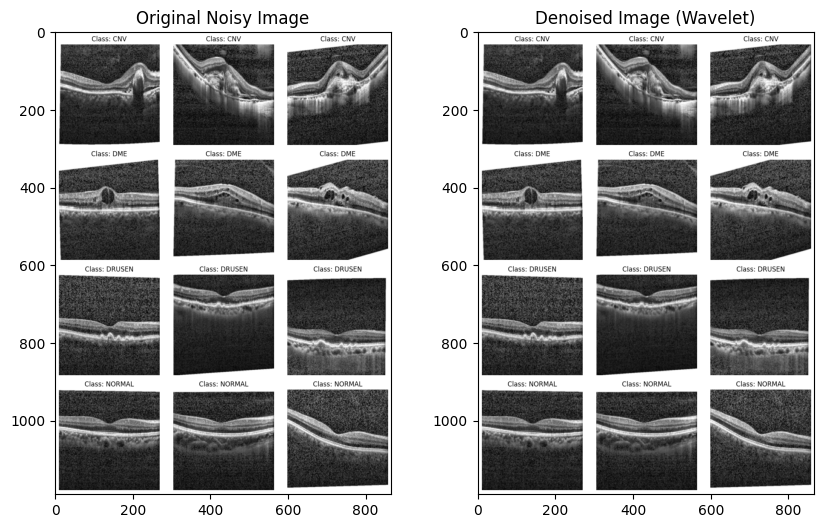

In [ ]:
import pywt
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the image as grayscale and convert to numpy array
image = Image.open('clahe.png').convert('L')
image_np = np.array(image)

# Apply wavelet transform
coeffs = pywt.wavedec2(image_np, 'db1', level=1)

# Coefficients: Approximation (coeffs[0]) and Detail (coeffs[1:])
cA, (cH, cV, cD) = coeffs[0], coeffs[1]  # Approximation and detail coefficients

# Set threshold
threshold = np.median(np.abs(cD)) / 0.6745

# Apply soft thresholding to the detail coefficients (horizontal, vertical, diagonal)
coeffs = [coeffs[0]] + [(pywt.threshold(cH, threshold, mode='soft'),
                         pywt.threshold(cV, threshold, mode='soft'),
                         pywt.threshold(cD, threshold, mode='soft'))]

# Reconstruct the denoised image from thresholded coefficients
denoised_image = pywt.waverec2(coeffs, 'db1')

# Clip values to fit valid pixel ranges and convert to uint8
denoised_image = np.clip(denoised_image, 0, 255).astype(np.uint8)

# Show before and after
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_np, cmap='gray')
plt.title('Original Noisy Image')

plt.subplot(1, 2, 2)
plt.imshow(denoised_image, cmap='gray')
plt.title('Denoised Image (Wavelet)')

plt.show()


In [ ]:
import pywt
import numpy as np
from PIL import Image
from torchvision import transforms

class WaveletDenoiseTransform:
    def __call__(self, img):
        # Convert image to grayscale numpy array
        img = np.array(img.convert('L'))
        # Perform wavelet decomposition
        coeffs = pywt.wavedec2(img, 'db1', level=2)
        # Set threshold for denoising
        threshold = np.median(np.abs(coeffs[-1])) / 0.6745
        # Apply soft thresholding to the coefficients (convert map object to list)
        coeffs = list(map(lambda x: pywt.threshold(x, threshold, mode='soft'), coeffs))
        # Reconstruct the denoised image
        denoised_img = pywt.waverec2(coeffs, 'db1')
        # Clip the values to fit valid pixel ranges and convert to uint8
        denoised_img = np.clip(denoised_img, 0, 255).astype(np.uint8)
        # Convert back to PIL Image
        return Image.fromarray(denoised_img)


In [ ]:
# Use the CLAHETransform in your transforms pipeline
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    
    ## Choose pre-processing ##
    # CLAHETransform(),  # Apply CLAHE
    # CannyEdgeTransform(),  # Apply Canny edge detection

    GaussianBlur(),  # Apply denoising
    # WaveletDenoiseTransform(),  # Apply wavelet denoising

    ## Augmentation ##
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(15),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),

    ## Choose pre-processing ##
    # CLAHETransform(),  # Apply CLAHE
    # CannyEdgeTransform(),  # Apply Canny edge detection

    GaussianBlur(),  # Apply denoising
    # WaveletDenoiseTransform(),  # Apply wavelet denoising

    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [ ]:
# Load training and testing datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

In [ ]:
classes = train_dataset.classes
classes

['CNV', 'DME', 'DRUSEN', 'NORMAL']

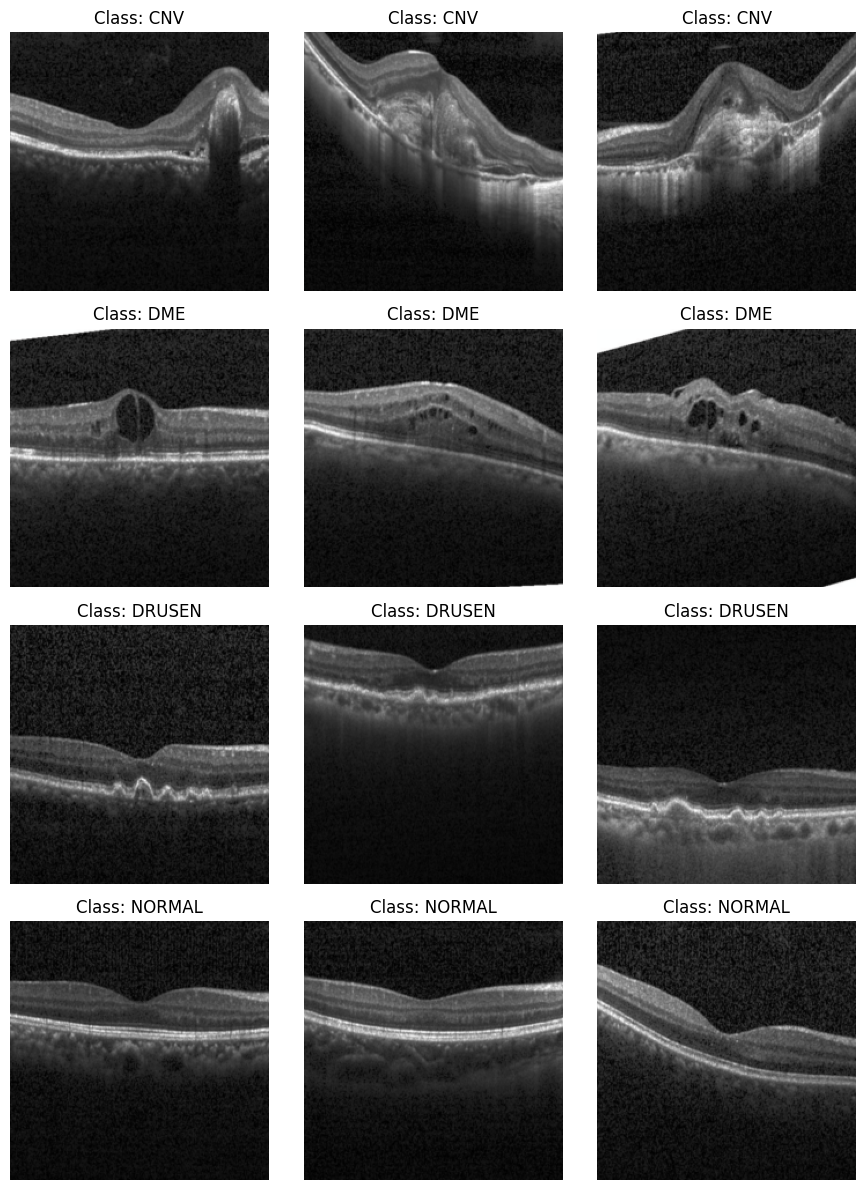

In [ ]:
visualize_samples(test_dataset, classes) ### RAW

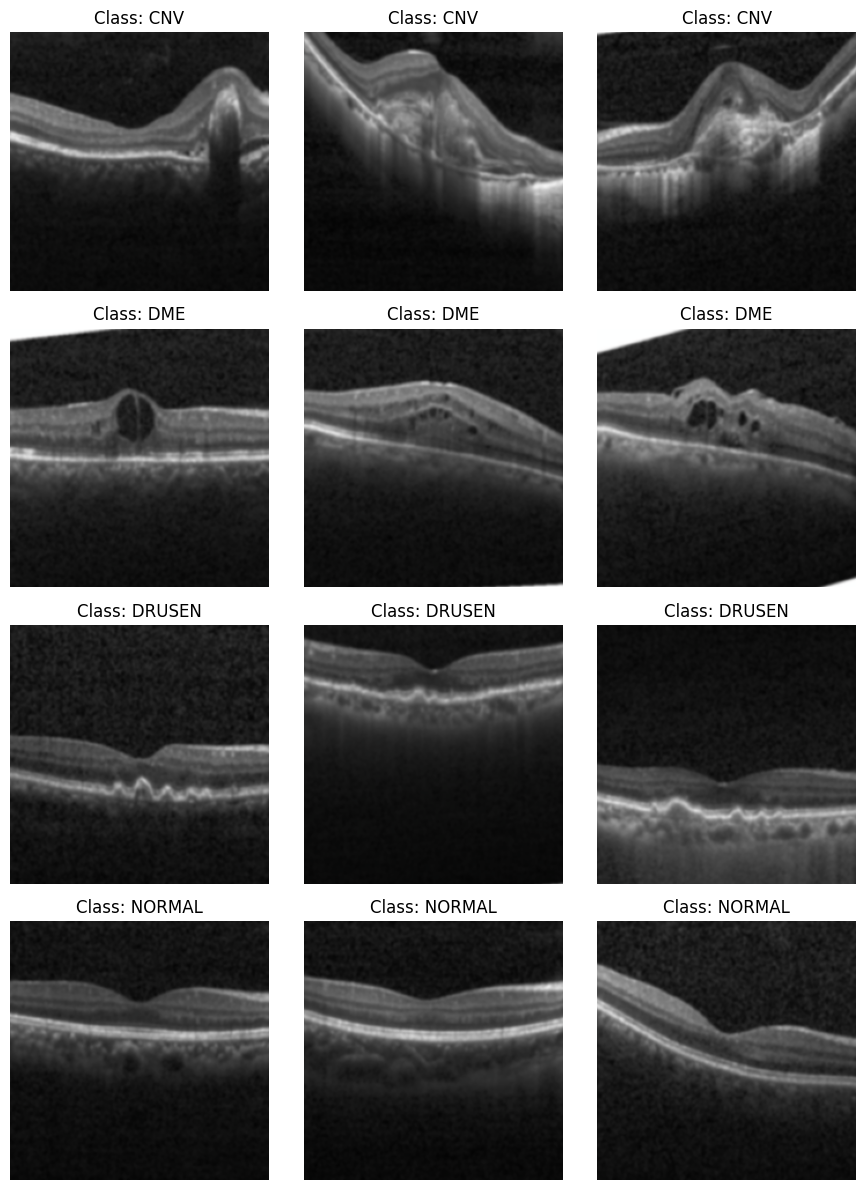

In [ ]:
visualize_samples(test_dataset, classes) ### Gaussian Blur

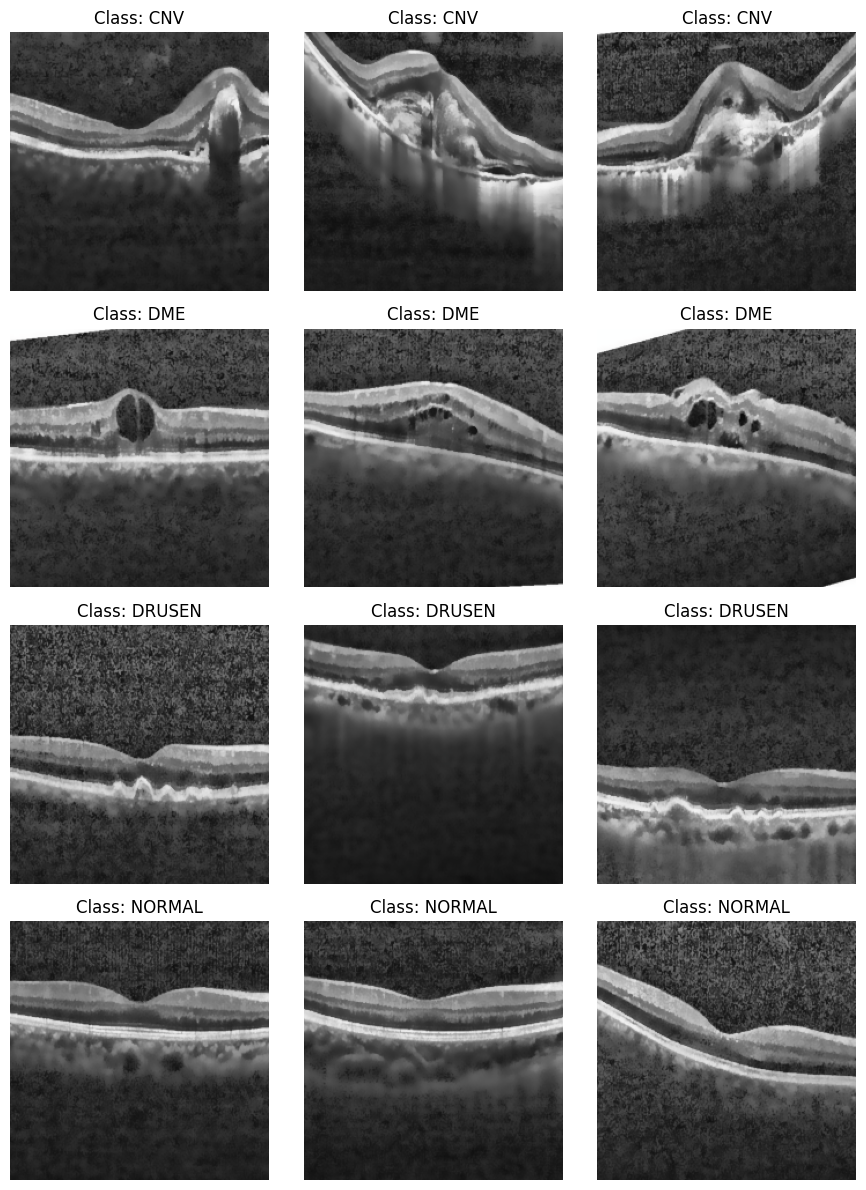

In [ ]:
visualize_samples(test_dataset, classes) ### CLAHE + Gaussian

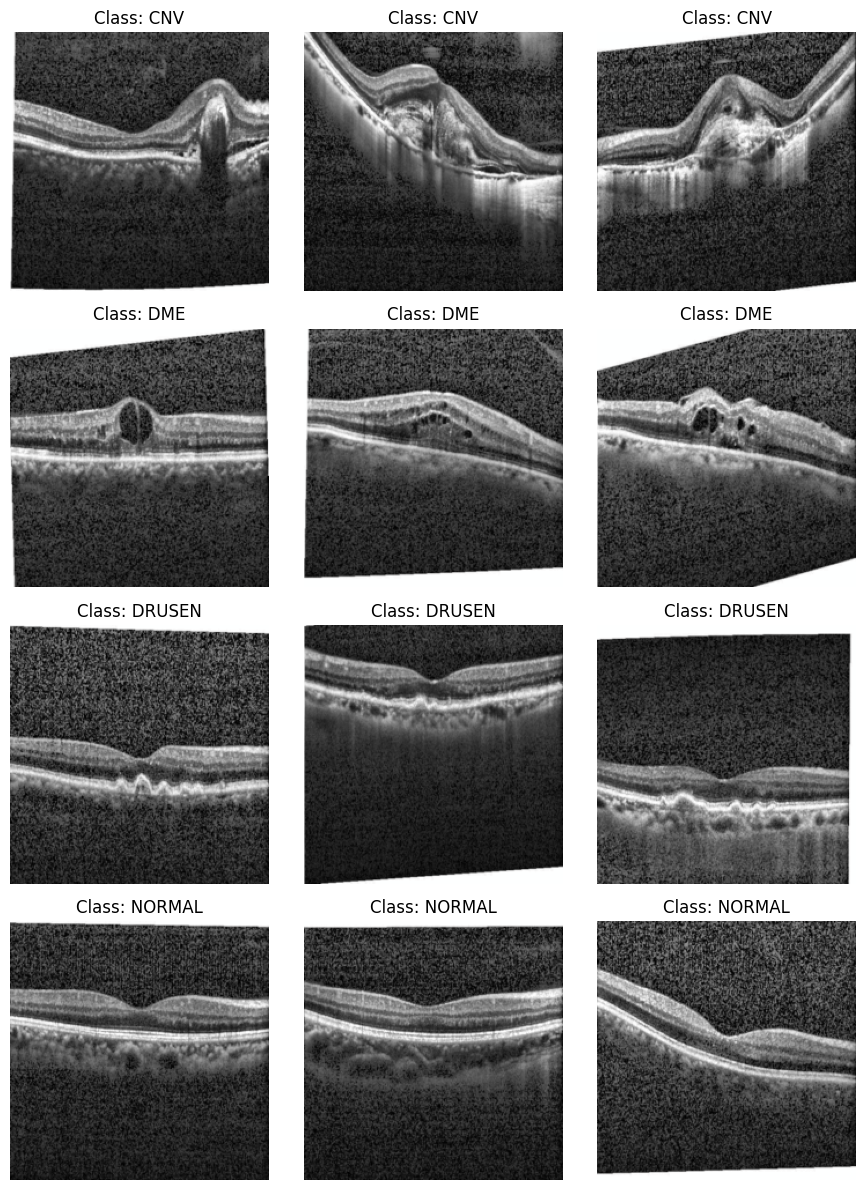

In [ ]:
visualize_samples(test_dataset, classes) ### CLAHE

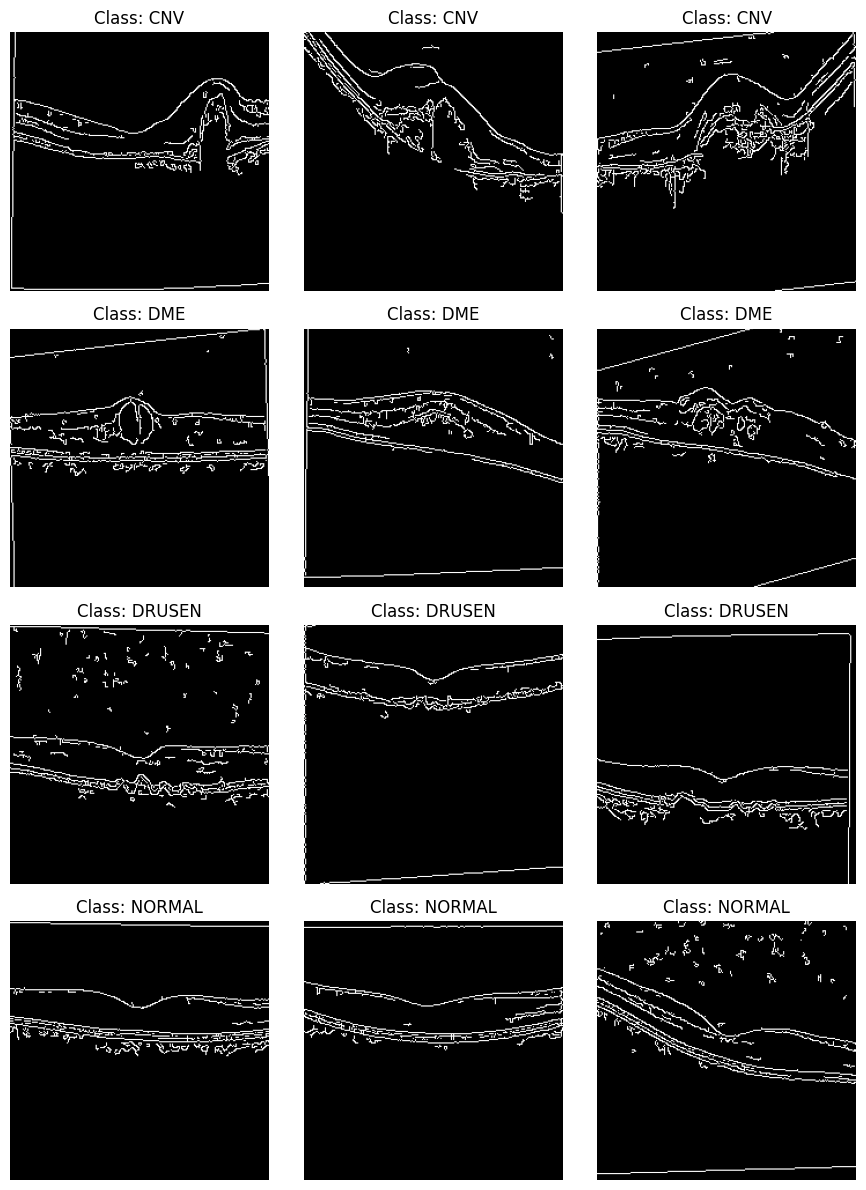

In [ ]:
visualize_samples(test_dataset, classes) ### Edge